# Southeastern Woody Wetland Analysis
This notebook outlines the scripting for the SE woody wetland analysis created by nmtarr in 2017. 

Overall, the processing for this analysis takes weeks to run. Therefore, code was written in manageable top-level scripts to be run sequentially, although some steps can run simultaneously.  Each step/script is listed below.  Slow scripts are referenced in markdown as running them here would be impractical while faster steps are active execfile statements so that results can be previewed here.


### Required code
Python 2.7
This repository includes an environment file (environment.pyl) that can be used to load most required packages with conda.  Several variables (paths to files and file names to use) are saved in a config fil named SEWWConfig.py.  In order to run the scripts, those would need to be updated to the users computing environment.

Additional code that is not available through pip or conda is needed as well:
arcpy 10.4.1;
GAPAnalysis >=0.3 available at https://github.com/nmtarr/GAPAnalysis; 
GAPProduction >=1.5.1 available at https://github.com/nmtarr/GAPProduction


### Required data
To run this analysis, you need access to 
GAP habitat maps (https://www.sciencebase.gov/catalog/item/527d0a83e4b0850ea0518326);
GAP WHR Database;
GAP Species Database;
GAP analytic database;
2001 GAP Land Cover (https://www.sciencebase.gov/catalog/item/5540e2d7e4b0a658d79395db);
Rasterized PAD-US data.

In [27]:
import os
os.chdir("P:/Proj3/USGap/Scripts/SE_Woody_Wetlands/")
%matplotlib inline
from IPython.display import Image
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 90)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import SEWWConfig as floodconfig

# Ecological Systems

### List southeastern woody wetland ecological systems
The wildlife-centric habitat classification can be used to reduce the number of candidate systems by excluding systems without trees or saturated soils.  The following code does that and creates a csv file named "saturated systems with trees" that has to be reviewed by humans to make final decisions about what should be included.

In [28]:
#execfile("DevelopSEWW-MUList.py")
rawList = pd.read_csv(floodconfig.intermDir + "saturated systems with trees.csv")
rawList2 = rawList.set_index(['map_code'])
rawList2.drop(['Unnamed: 0'], inplace=True, axis=1)
print(rawList2)

                                                                                        system_name
map_code                                                                                           
9218                                             Atlantic Coastal Plain Southern Tidal Wooded Swamp
9302      Atlantic Coastal Plain Nonriverine Swamp and Wet Hardwood Forest - Oak Dominated Modifier
9601                                             Northern Atlantic Coastal Plain Pitch Pine Lowland
9303                                Atlantic Coastal Plain Clay-Based Carolina Bay Forested Wetland
9235                                             Atlantic Coastal Plain Northern Tidal Wooded Swamp
9237                                           West Gulf Coastal Plain Near-Coast Large River Swamp
9238                                                                    South Florida Bayhead Swamp
9239                                                 Southern Coastal Plain Nonriverine Basin Swamp


### Review "Saturated systems with trees"
The ecological system list was reviewed by N. Tarr, A. McKerrow, and A. Davidson.  Some hydric hammock systems were added to the list.  Below are systems that were excluded before saving in "Ecological systems of interest.csv"

In [29]:
dropMUs = pd.read_csv(floodconfig.SEWWSystemCSV)
dropMUs = dropMUs[dropMUs['include'] == 0]
dropMUs.drop(['Unnamed: 0', 'yes Anne', 'yesAlexa', 'past', 'include'], axis=1, inplace=True)
dropMUs.set_index('map_code', inplace=True)
print(dropMUs)

                                                                                        system_name
map_code                                                                                           
 4504.0       Atlantic Coastal Plain Fall-Line Sandhills Longleaf Pine Woodland - Loblolly Modifier
 4553.0   Atlantic Coastal Plain Fall-line Sandhills Longleaf Pine Woodland - Offsite Hardwood M...
 4505.0   Atlantic Coastal Plain Fall-line Sandhills Longleaf Pine Woodland - Open Understory Mo...
 4506.0   Atlantic Coastal Plain Fall-line Sandhills Longleaf Pine Woodland - Scrub/Shrub Unders...
 4212.0                                             Atlantic Coastal Plain Southern Maritime Forest
 9501.0                                                              Boreal Acidic Peatland Systems
 9802.0                                            Central Appalachian Floodplain - Forest Modifier
 9818.0                                         Central Interior and Appalachian Floodplain Systems


### Map the ecological systems of interest
Create a binary map of the systems of interest with values of 1 (cell is a system of interest) and 0 (cell is not a system of interest). 

execfile("MapSEWW.py")

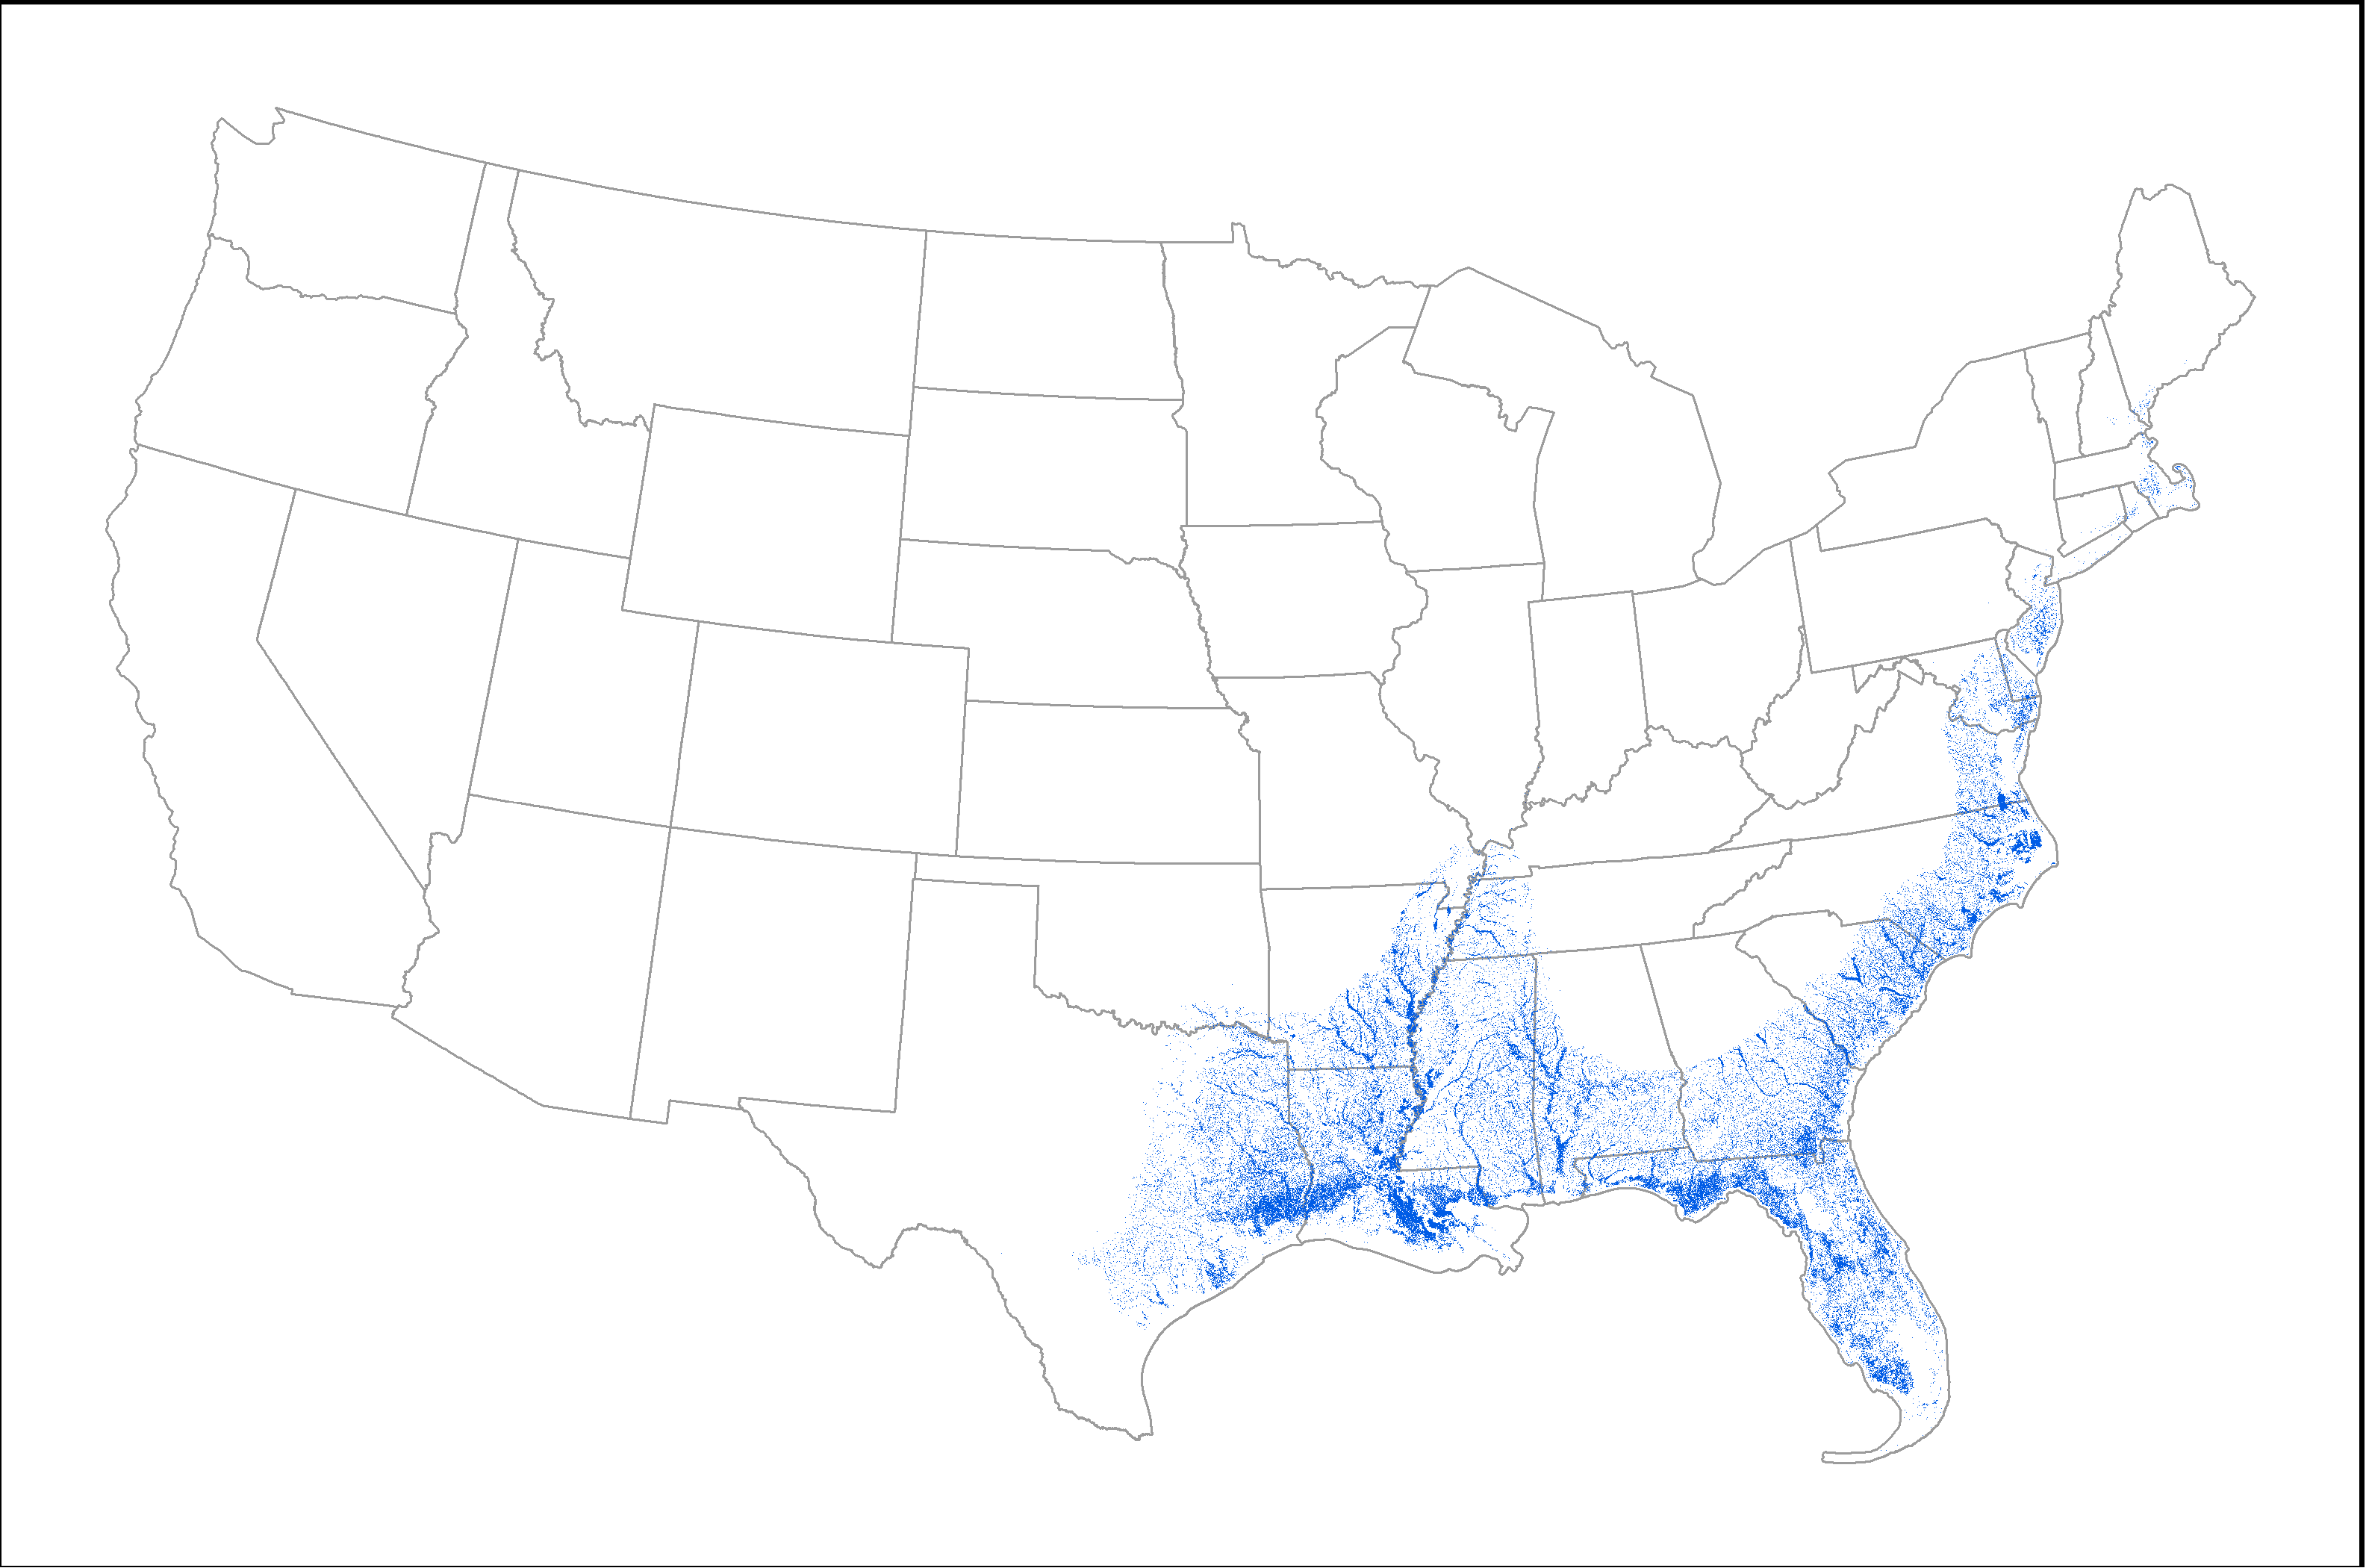

In [30]:
Image(filename=floodconfig.resultDir + 'SEWW.png') 

# Species Richness

### Mask species richness maps to SE and SEWW
Maps of national species richness, southeastern species richness, and species richness in SEWW's are needed.  Mask national richness maps to get those.

execfile("MaskSpeciesRichness.py")

### Compare species richness on SEWW to CONUS and SE richness
Create figures that display comparison of species richness on SEWW to richness at other extents.

reptile
{'75th': 17, 'name': 'CONUS', '50th': 10, 'standard_deviation': 9.3509842650514, 'range': (1, 54), '25th': 6, 'mean': 12.53206006621209}
{'75th': 22, 'name': 'Southeast', '50th': 15, 'standard_deviation': 8.2160519881217, 'range': (1, 50), '25th': 10, 'mean': 16.78904524425563}
{'75th': 32, 'name': 'SEWW', '50th': 26, 'standard_deviation': 7.2821075872471, 'range': (1, 51), '25th': 20, 'mean': 25.63412363843866}
bird_winter
{'75th': 44, 'name': 'CONUS', '50th': 35, 'standard_deviation': 20.382840246725, 'range': (1, 143), '25th': 27, 'mean': 35.94103714752577}
{'75th': 56, 'name': 'Southeast', '50th': 49, 'standard_deviation': 12.567004685723, 'range': (1, 142), '25th': 42, 'mean': 48.87395660525394}
{'75th': 59, 'name': 'SEWW', '50th': 54, 'standard_deviation': 7.8500613342374, 'range': (3, 86), '25th': 48, 'mean': 53.863319427478956}
bird_summer
{'75th': 56, 'name': 'CONUS', '50th': 48, 'standard_deviation': 25.953168085337, 'range': (1, 127), '25th': 39, 'mean': 46.799930768

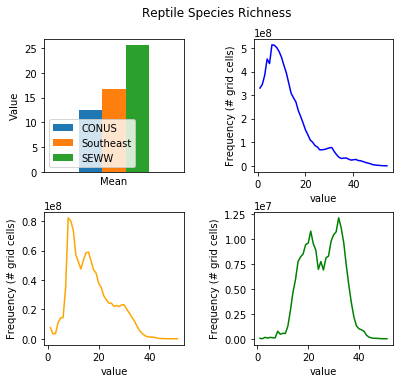

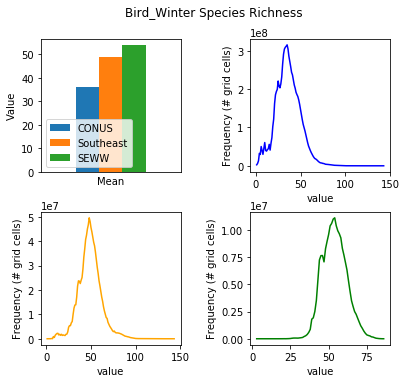

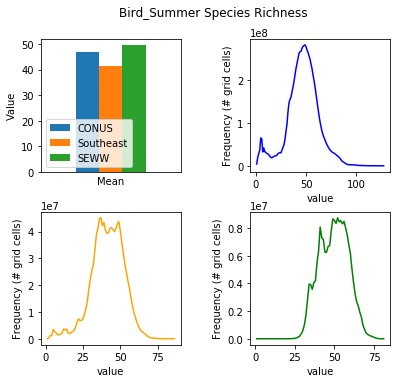

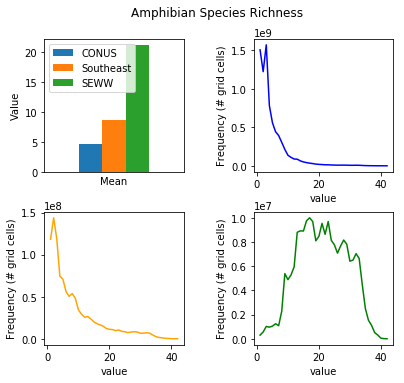

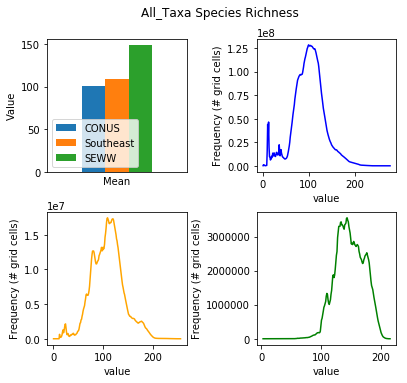

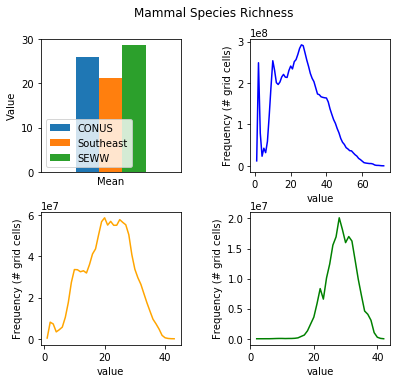

In [31]:
execfile("CompareRichness.py")

# Terrestrial Vertebrates

### Get species list for study region
Whittle down the list of species to apply the slow geoprocessing to.
The only species that need to be assessed are ones that are in the general study
region and are associated with one of the ecological systems of interest in the 
database OR are handmodeled.  This code seeks to build that list.

execfile("GetStudyRegionSpeciesList.py")

### Calculate percent habitat in SEWW for species
Overlay each species' habitat map with the binary map of SEWW's to determine how much of each species habitat is in SEWW's.  Results are saved in a table.
Note: this process would take about a month to run if species are assessed one at a time.  Therefore, the script is written so that (manually) be run in 4 separate groups; each group can be run in its own python shell using spyder.  Run time is a little over a week when doing that.

execfile("CalculatePercentHabitatInSEWW.py")

In [32]:
SEWWsp = pd.read_csv(floodconfig.resultDir + "Species that use SEWW systems.csv")
SEWWsp.drop(inplace=True, axis=1, columns=["Unnamed: 0"])
SEWWsp.set_index(['scientific_name'], inplace=True)
SEWWsp['PercSummer'] = [int(round(x)) for x in SEWWsp.PercSummer]
SEWWsp['PercWinter'] = [int(round(x)) for x in SEWWsp.PercWinter]
SEWWsp.rename(columns={"PercSummer": "percent_summer", "PercWinter": "percent_winter"}, inplace=True)
SEWWsp = SEWWsp[['common_name', 'percent_summer', 'percent_winter']]
print(SEWWsp)

                                                            common_name  percent_summer  percent_winter
scientific_name                                                                                        
Oryzomys palustris natator                                 Key Oryzomys               1               1
Plethodon chlorobryonis                 Atlantic Coast Slimy Salamander              53              53
Pseudacris brimleyi                               Brimley's Chorus Frog              94              94
Ambystoma mavortium                             Barred Tiger Salamander               0               0
Hyla avivoca                                       Bird-voiced Treefrog              96              96
Hyla chrysoscelis                                  Cope's Gray Treefrog              13              13
Eurycea chamberlaini                     Chamberlain's Dwarf Salamander              78              78
Eurycea lucifuga                                        Cave Sal

### Summarize species' overlap with SEWW's; find "top SEWW" species
The previous step produced a table that can be used for determining which species rely the most heavily on SEWW and summarizing the amount of habitat for species in SEWW.

When determining which species rely "the most", this script is currently set to use a 50% cutoff: species with >50% of their habitat in SEWW make the cut.

638 species use the systems of interest

87 species with more than 50.0% of winter habitat in SEWW:
	Atlantic Coast Slimy Salamander
	Brimley's Chorus Frog
	Bird-voiced Treefrog
	Chamberlain's Dwarf Salamander
	Dwarf Waterdog
	Florida Bog Frog
	Frosted Flatwoods Salamander
	Greater Siren
	Louisiana Slimy Salamander
	Little Grass Frog
	Many-lined Salamander
	Southern Cricket Frog
	Southern Dwarf Siren
	Savannah Slimy Salamander
	Great Egret
	Alligator Snapping Turtle
	Cottonmouth
	Eastern Musk Turtle
	Mississippi Green Watersnake
	Plain-bellied Watersnake
	Red-bellied Mudsnake
	Striped Mud Turtle
	Mole Salamander
	Reticulated Flatwoods Salamander
	Small-mouthed Salamander
	Southern Dusky Salamander
	Squirrel Treefrog
	Striped Newt
	Three-toed Amphiuma
	Two-toed Amphiuma
	Great Crested Flycatcher
	Prothonotary Warbler
	Purple Gallinule
	Swamp Rabbit
	Black Swampsnake
	Chicken Turtle
	Eastern Mud Turtle
	Escambia Map Turtle
	Florida Crowned Snake
	Graham's Crayfish Snake
	Island Glass Liz

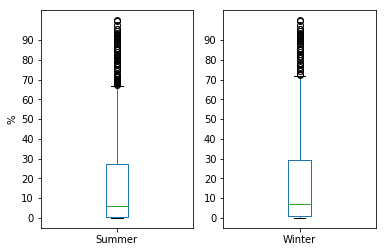

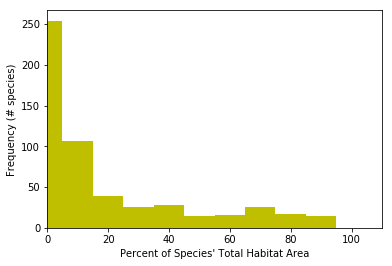

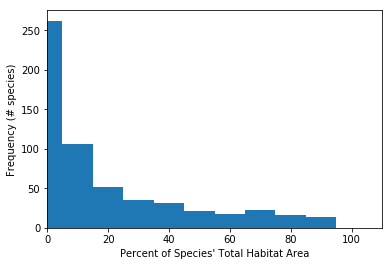

In [33]:
execfile("SummarizeOverlap.py")

### Map richness of top SEWW species for summer and winter
With the species with >50% of their habitat in SEWW identified, we can now map their richness.

execfile("MapSEWWSpeciesRichness.py")

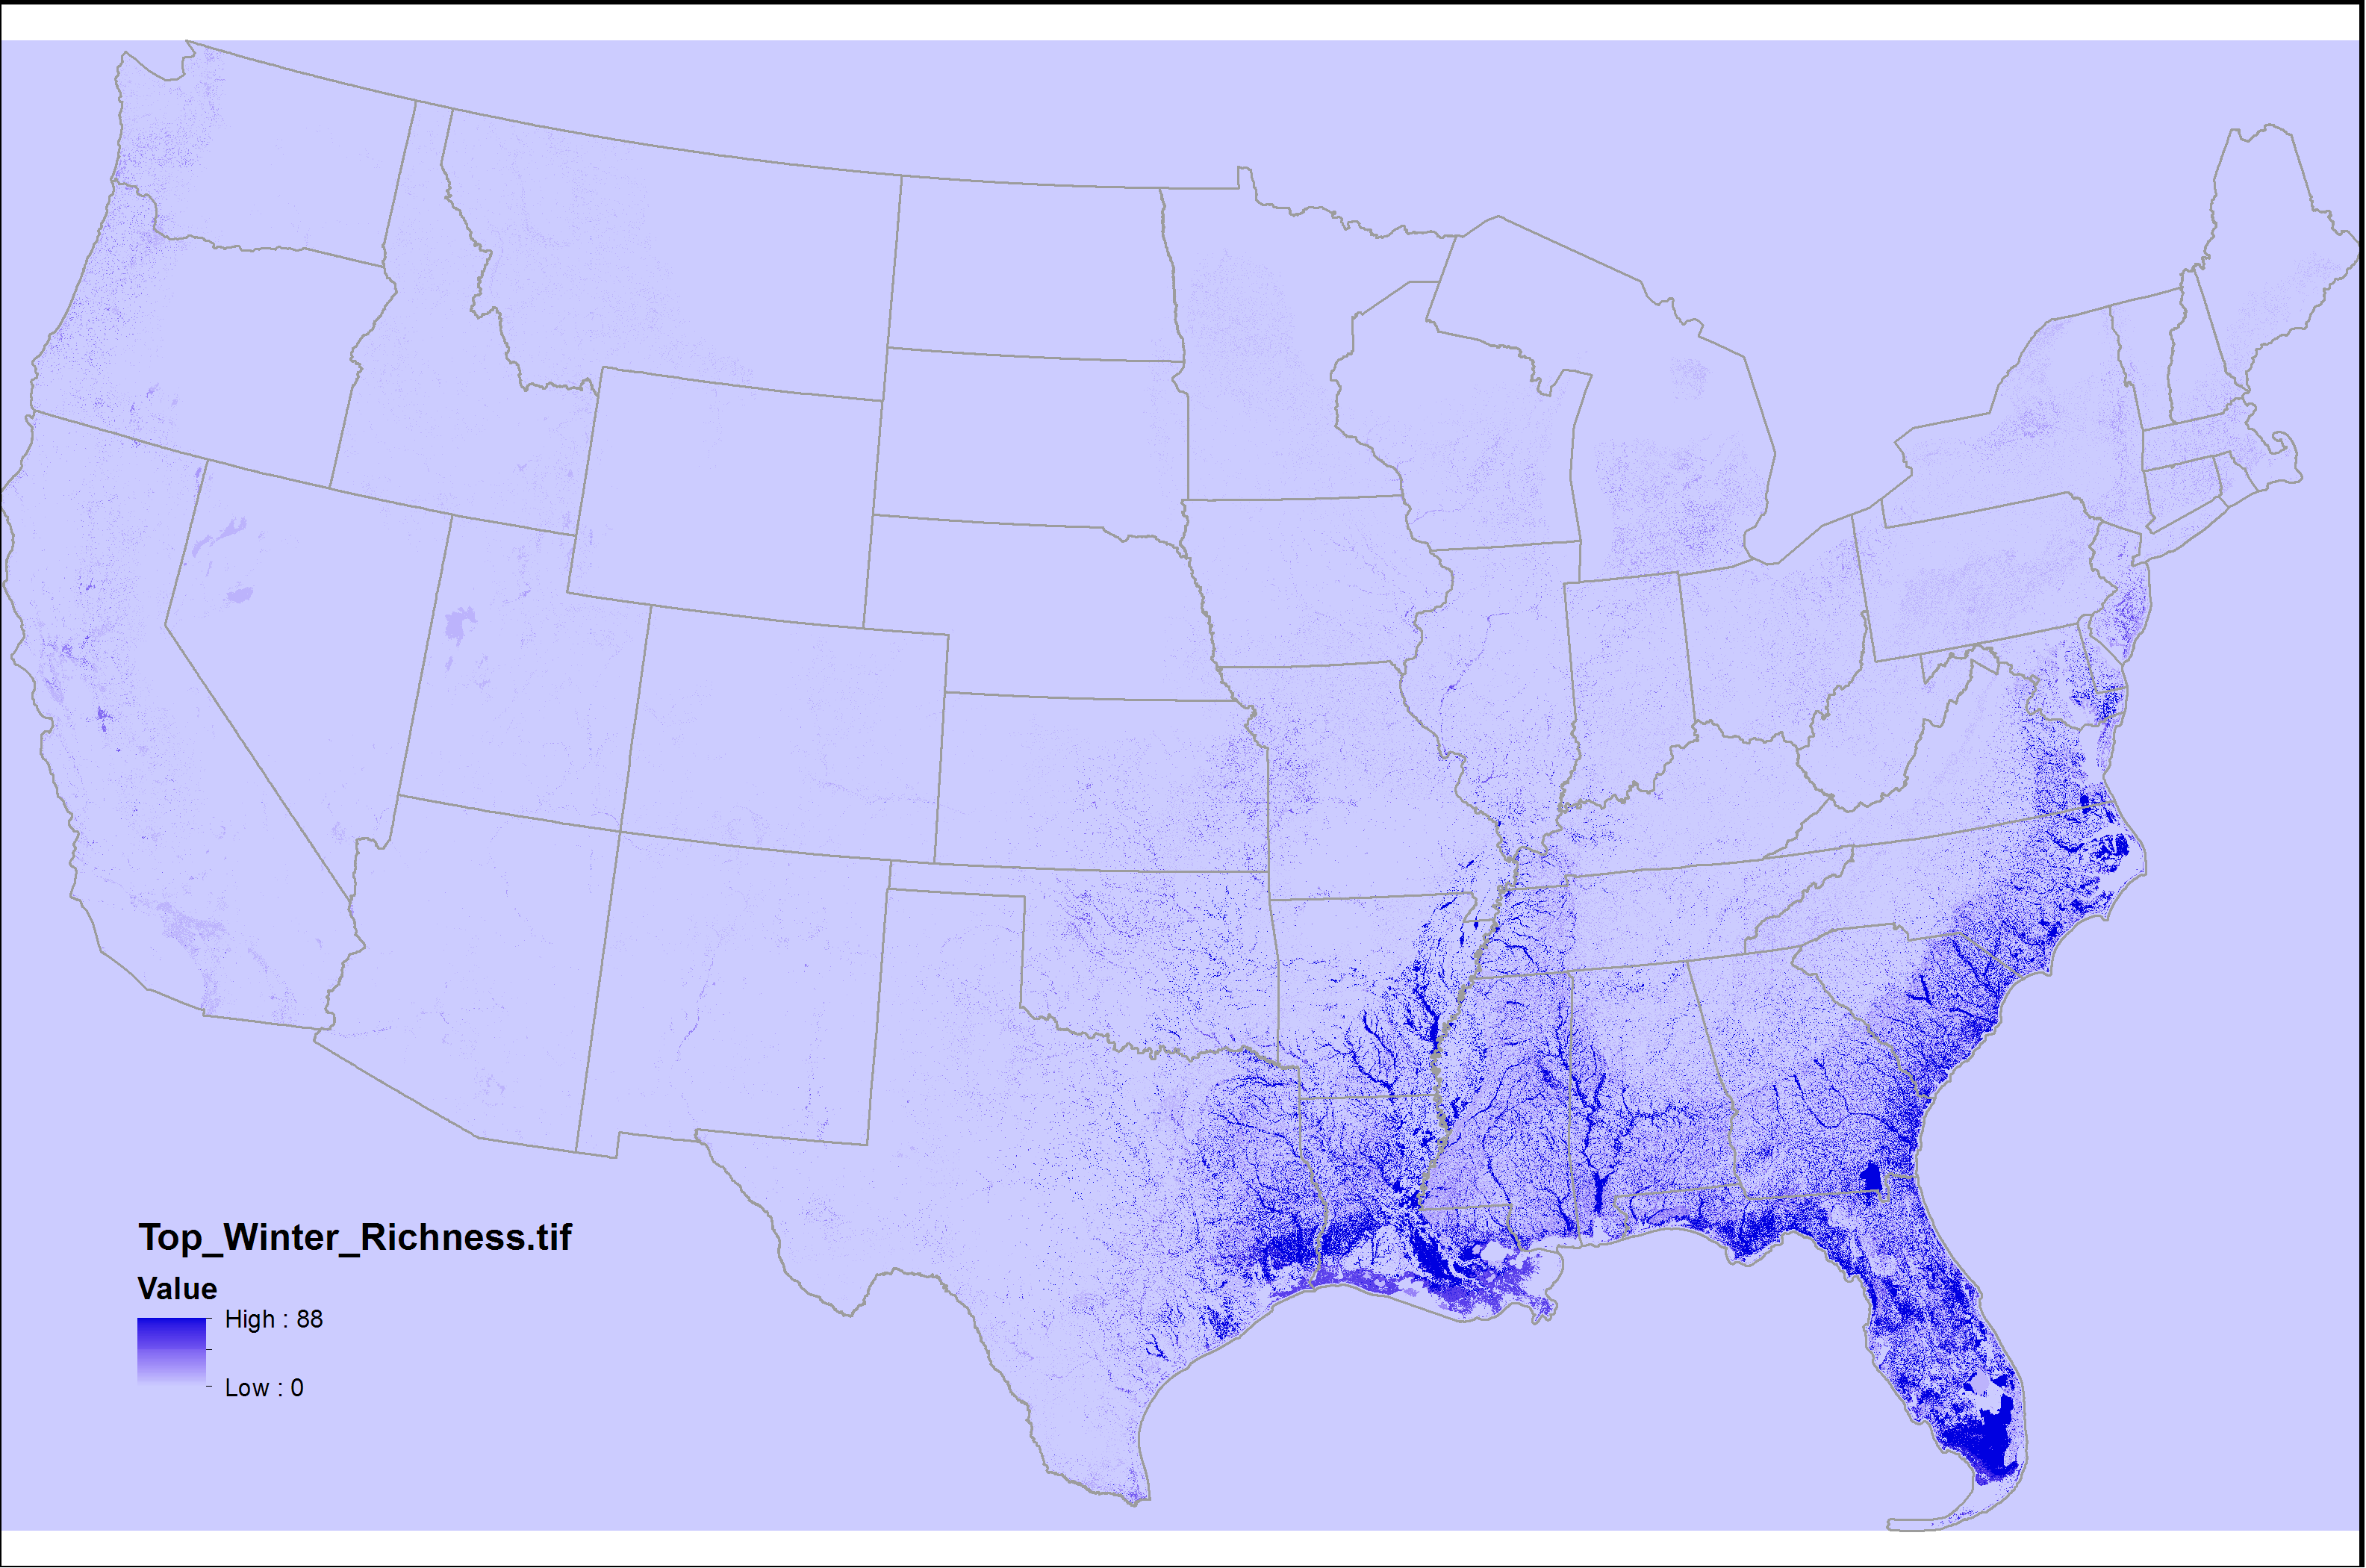

In [34]:
Image(filename=floodconfig.resultDir + 'top_winter_richness.png') 

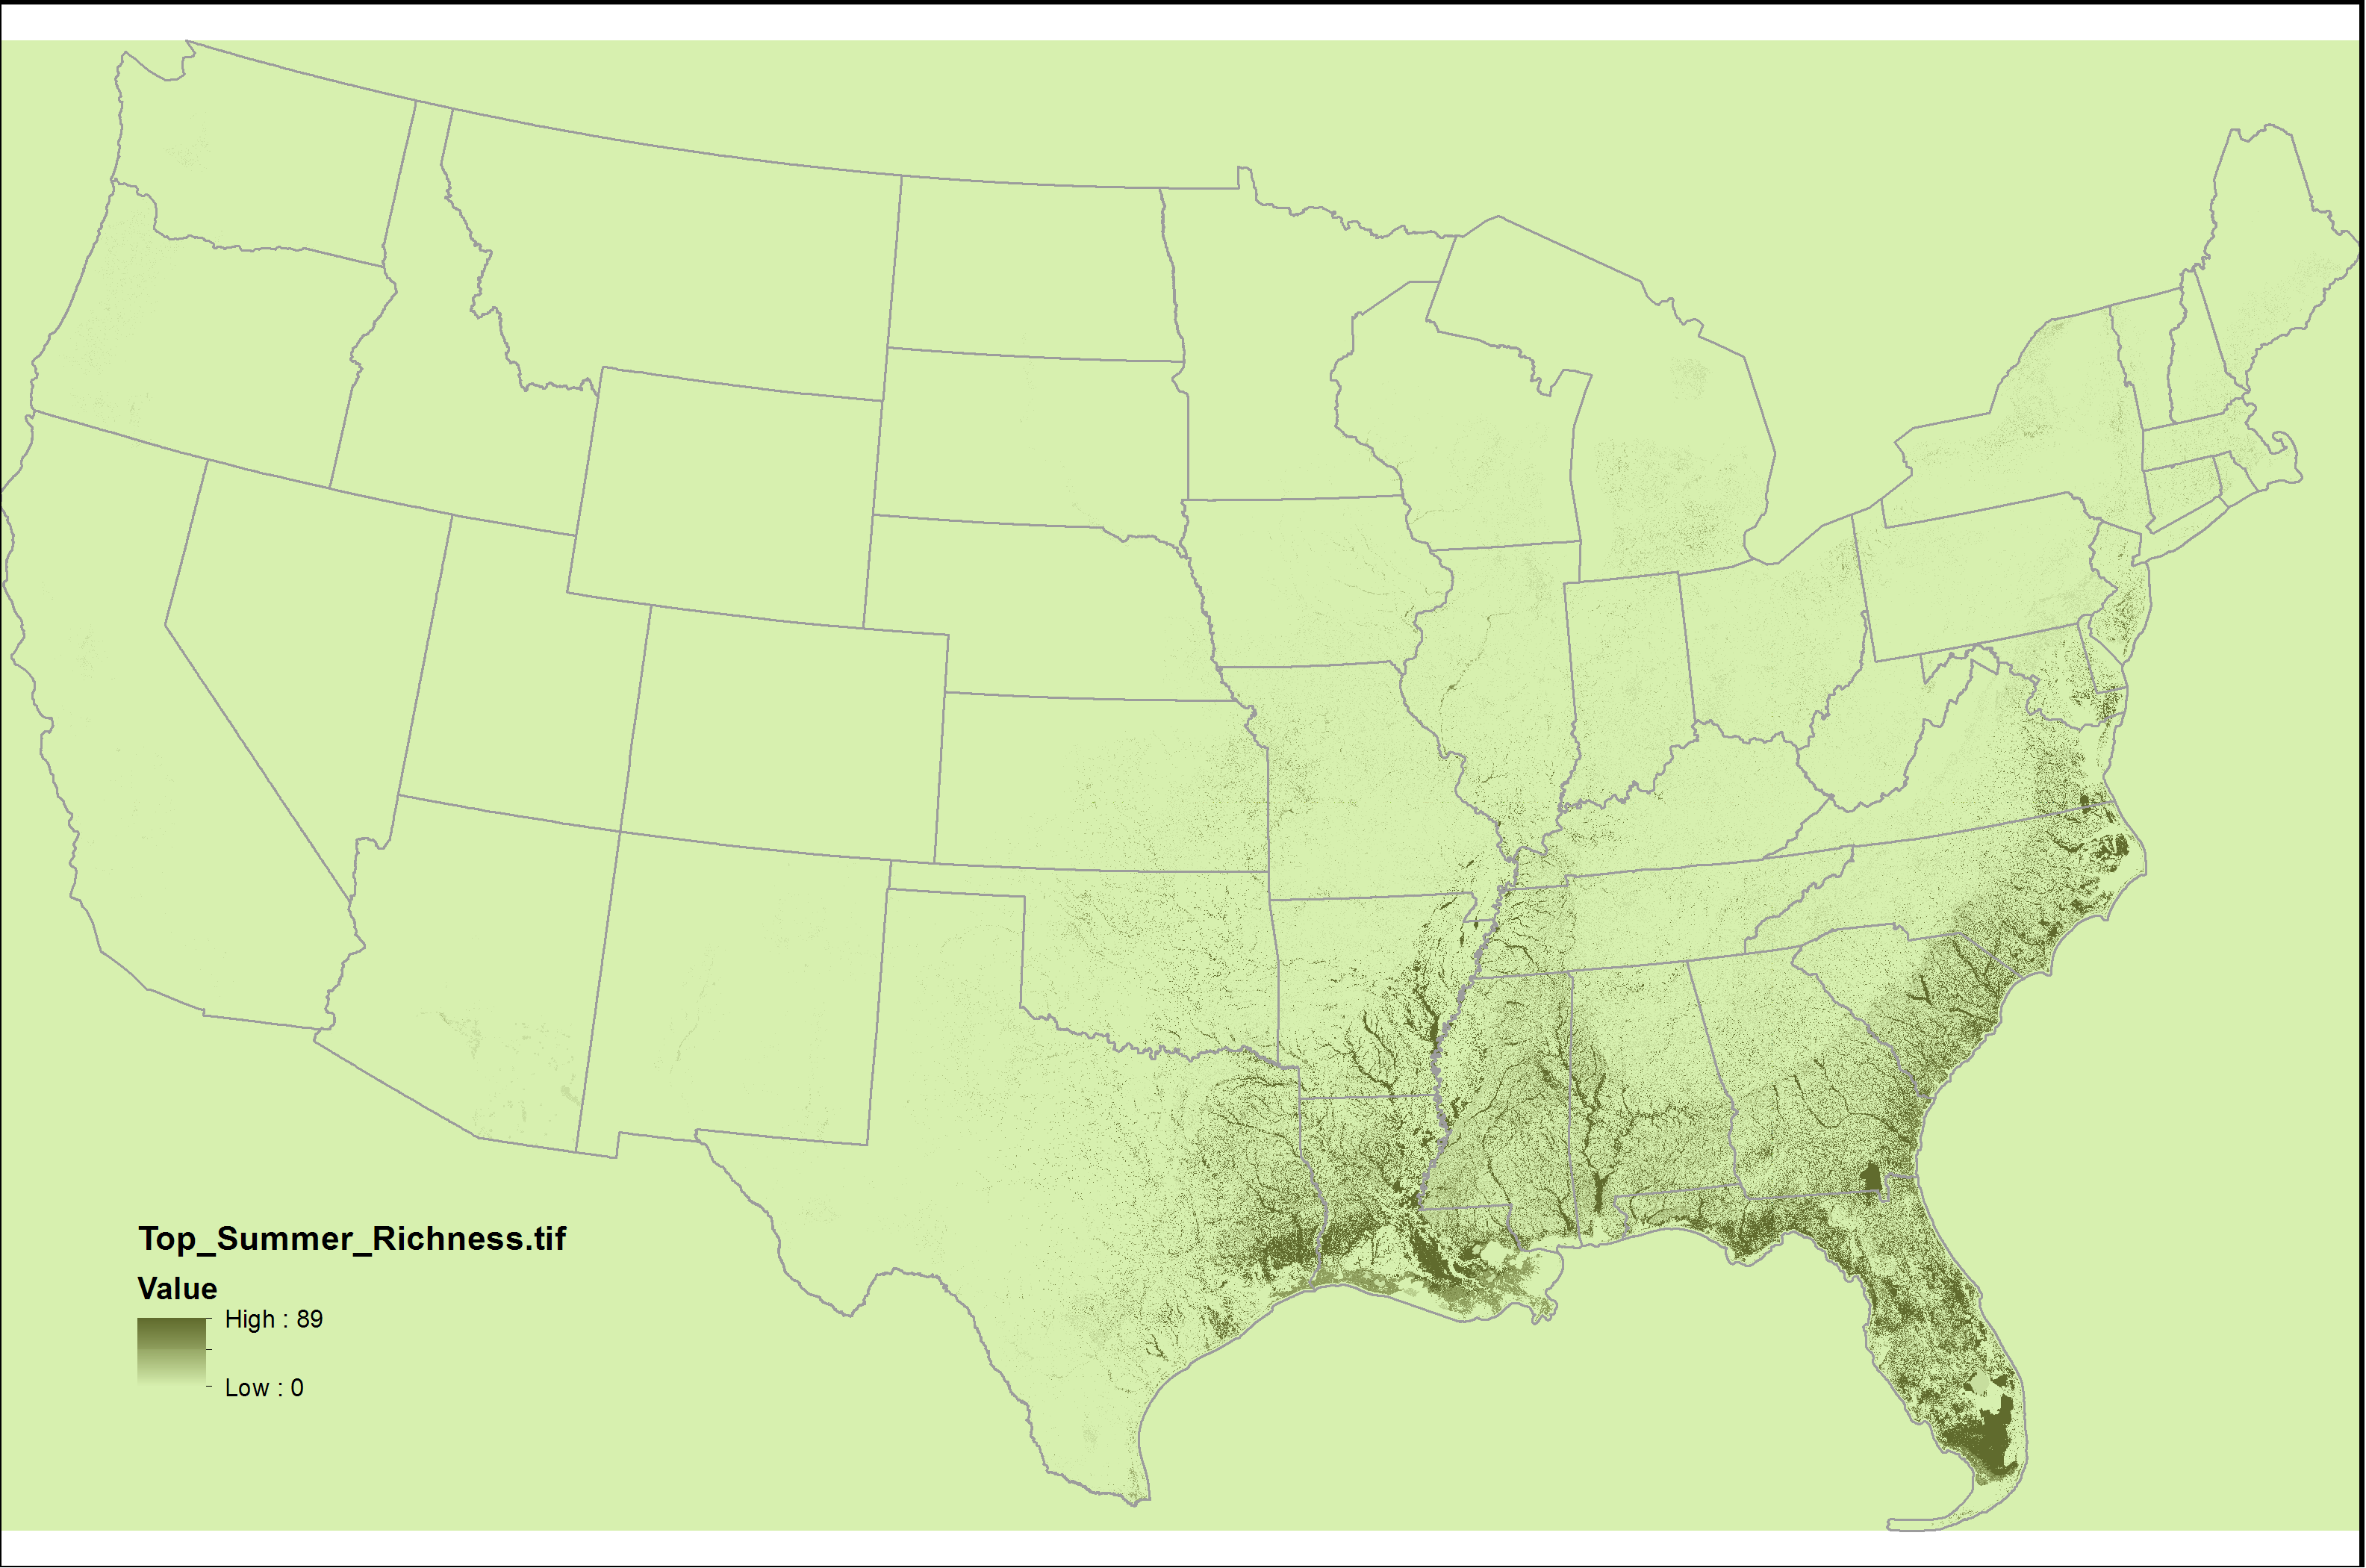

In [35]:
Image(filename=floodconfig.resultDir + 'top_summer_richness.png') 

# Protection

### Assess the protection of SEWW systems and species
Determine how much of each SEWW system and SEWW species' habitat is in each of the GAP protection classes.

MakeSEWWPAD.py takes over an hour to run.

execfile("MakeSEWWPAD.py")

C:\Users\nmtarr\AppData\Local\Continuum\anaconda2\envs\SEWoodyWetlands\lib\site-packages\ipykernel_launcher.py:100: RuntimeWarning: divide by zero encountered in longlong_scalars



*** SUMMER ***
           status_1      status_2      status_3      status_4   total_cells  status_1%  status_2%  status_3%  status_4%
count  8.800000e+01  8.800000e+01  8.800000e+01  8.800000e+01  8.800000e+01  88.000000  88.000000  88.000000  88.000000
mean   2.261859e+06  5.493511e+06  7.460265e+06  3.007690e+06  1.822333e+07  10.521352  29.138205  40.549837  19.790606
std    2.455189e+06  5.120690e+06  6.939911e+06  2.632296e+06  1.627048e+07   8.779516  14.113679  14.103949  13.184868
min    0.000000e+00  1.913000e+03  6.920000e+02  7.380000e+02  2.676300e+04   0.000000   1.607968   0.615656   1.205356
25%    2.718388e+05  8.686082e+05  1.704635e+06  6.669488e+05  3.737730e+06   4.088785  18.841316  29.844712  13.958443
50%    1.343385e+06  4.683724e+06  4.657220e+06  2.761104e+06  1.552194e+07  10.031553  28.537067  41.106123  16.347612
75%    3.829532e+06  8.409699e+06  1.198882e+07  4.517736e+06  2.926818e+07  13.585284  37.216180  48.880853  20.967282
max    1.006490e+07  1.8

C:\Users\nmtarr\AppData\Local\Continuum\anaconda2\envs\SEWoodyWetlands\lib\site-packages\ipykernel_launcher.py:307: RuntimeWarning: invalid value encountered in double_scalars


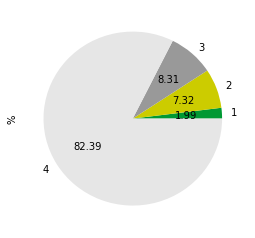

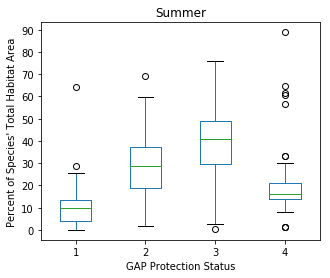

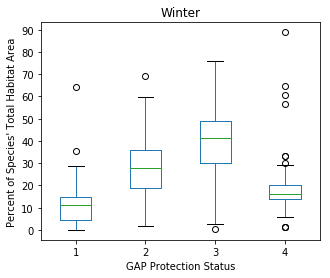

In [40]:
execfile("AssessProtection.py")
# The runtime warnings "divide by zero encountered in longlong_scalars" and 'invalid value encountered in double_scalars'
# can be ignored, it is returned because of a sum method used on a dataframe with values of '0'.

In [41]:
sysProt = pd.read_csv(floodconfig.resultDir + "EcolSysProtection.csv", 
                      usecols=["map_code", "system_name", "protected1&2(%)"],
                      index_col="map_code", 
                      dtype={"map_code": int, "protected1&2(%)":float})
print("Southeastern Woody Wetland Ecological System Protection")
print(sysProt.round(2))

Southeastern Woody Wetland Ecological System Protection
                                                                                        system_name  protected1&2(%)
map_code                                                                                                            
9801                   Atlantic Coastal Plain Blackwater Stream Floodplain Forest - Forest Modifier            29.35
9845                                     Atlantic Coastal Plain Brownwater Stream Floodplain Forest           100.00
4210                                                 Atlantic Coastal Plain Central Maritime Forest            36.81
9303                                Atlantic Coastal Plain Clay-Based Carolina Bay Forested Wetland            81.33
9716                                                    Atlantic Coastal Plain Depression Pondshore            84.77
9215                                                 Atlantic Coastal Plain Large Natural Lakeshore            29.14
9301    

In [42]:
sumProt = pd.read_csv(floodconfig.resultDir + "Summer protection.csv", 
                      usecols=["Unnamed: 0", "status_1%", "status_2%", "status_3%", "status_4%"],
                     index_col="Unnamed: 0")
sumProt['common_name'] = [gp.gapdb.NameCommon(x) for x in sumProt.index]
sumProt = sumProt[["common_name", "status_1%", "status_2%", "status_3%", "status_4%"]]
sumProt.index.name="strUC"
print("Protection of top SEWW-summer species")
print(sumProt.round(2))

Protection of top SEWW-summer species
                             common_name  status_1%  status_2%  status_3%  status_4%
strUC                                                                               
aACSSx   Atlantic Coast Slimy Salamander       9.93      35.75      27.31      27.02
aBRFRx             Brimley's Chorus Frog       9.79      45.21      28.71      16.29
aBVTRx              Bird-voiced Treefrog       3.39      48.64      31.38      16.59
aCHDSx    Chamberlain's Dwarf Salamander      11.14      29.21      30.56      29.08
aDWWAx                    Dwarf Waterdog       7.48      49.12      21.56      21.84
aFBFRx                  Florida Bog Frog       0.65       1.65      37.15      60.55
aFFSAx      Frosted Flatwoods Salamander      23.71      11.22      50.94      14.12
aGRSIx                     Greater Siren      13.65      24.52      47.34      14.49
aLASAx        Louisiana Slimy Salamander       1.00      69.35      28.40       1.24
aLGFRx                 Litt

In [43]:
winProt = pd.read_csv(floodconfig.resultDir + "Winter protection.csv", 
                      usecols=["Unnamed: 0", "status_1%", "status_2%", "status_3%", "status_4%"],
                     index_col="Unnamed: 0")
winProt['common_name'] = [gp.gapdb.NameCommon(x) for x in winProt.index]
winProt = winProt[["common_name", "status_1%", "status_2%", "status_3%", "status_4%"]]
winProt.index.name="strUC"
print("Protection of top SEWW-winter species")
print(sumProt.round(2))

Protection of top SEWW-winter species
                             common_name  status_1%  status_2%  status_3%  status_4%
strUC                                                                               
aACSSx   Atlantic Coast Slimy Salamander       9.93      35.75      27.31      27.02
aBRFRx             Brimley's Chorus Frog       9.79      45.21      28.71      16.29
aBVTRx              Bird-voiced Treefrog       3.39      48.64      31.38      16.59
aCHDSx    Chamberlain's Dwarf Salamander      11.14      29.21      30.56      29.08
aDWWAx                    Dwarf Waterdog       7.48      49.12      21.56      21.84
aFBFRx                  Florida Bog Frog       0.65       1.65      37.15      60.55
aFFSAx      Frosted Flatwoods Salamander      23.71      11.22      50.94      14.12
aGRSIx                     Greater Siren      13.65      24.52      47.34      14.49
aLASAx        Louisiana Slimy Salamander       1.00      69.35      28.40       1.24
aLGFRx                 Litt

# Build pyramids for raster layers
Pyramids enable faster viewing of data layers, but not they take a long time to create.

execfile("BuildPyramids.py")